<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

### Task 1: Import Packages and Functions

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.2.0


### Task 2: Load and Explore Data

In [3]:
# Load data
train_df= pd.read_csv('train.csv').fillna(' ')

In [4]:
train_df.sample(10,random_state=1)

,comment_text,toxic
24915,"YOU ARE A FAT, GEEKY PRICK WHO HAS NOTHING TO ...",1
75819,Agent X2: Basically thanks - with a 'little' m...,0
53891,Why are my posts being deleted? \n\nI have tri...,0
154159,"""\n\n Controlled Demolitions and Common Sense ...",0
13040,I do not understand your reply. //Blaxthos ( ...,0
123190,Is this the bizarro world? Removing content is...,0
33626,"Well, WP:RS says that articles should use reli...",0
1150,Oh hear me go someone removes all my pages i g...,0
48633,can't believe this article was deleted\nI'm su...,0
42817,"""\n\n Comments on GamerGate Workshop page \n\n...",0


In [5]:
# View few toxic comments
x = train_df['comment_text']
y = train_df['toxic']

In [6]:
train_df[train_df.toxic==1]

,comment_text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...
159494,"""\n\n our previous conversation \n\nyou fuckin...",1
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159541,Your absurd edits \n\nYour absurd edits on gre...,1
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",1


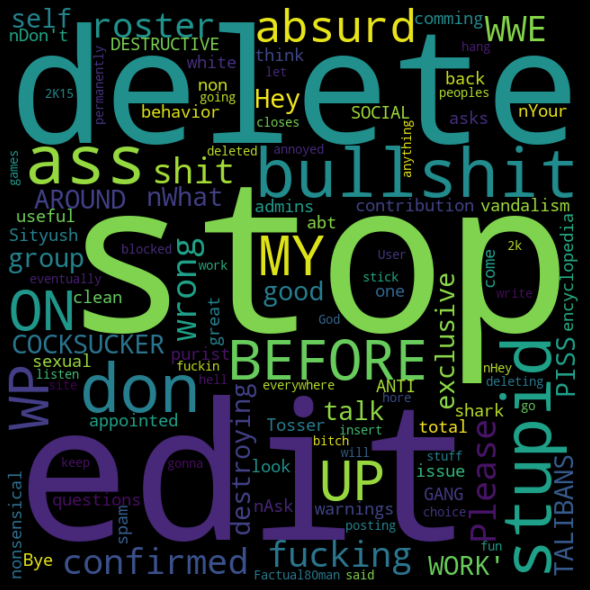

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


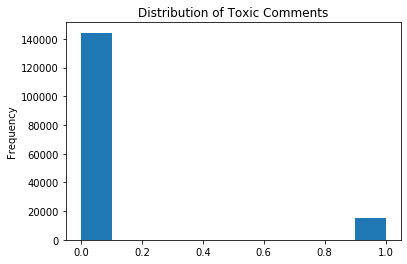

In [8]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind='hist',title='Distribution of Toxic Comments')

In [10]:
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

### Task 3: Data Prep — Tokenize and Pad Text Data

In [11]:
max_features = 20000
max_text_length = 400

In [12]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

In [13]:
x_tokenized =x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized,maxlen=max_text_length)

### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [14]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [18]:
embedding_dim =100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [22]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector
            

### Task 5: Create the Embedding Layer

In [24]:
model = Sequential()
model.add(Embedding(max_features,embedding_dim,embeddings_initializer=tf.initializers.Constant(embedding_matrix),trainable=False))
model.add(Dropout(0.2))

### Task 6: Build the Model

In [29]:
filters= 250
kernel_size=3
hidden_dims= 250


In [63]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 250)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)              

### Task 7: Train Model

In [64]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [65]:
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y,test_size=0.15,random_state=1)

In [66]:
batch_size= 32
epochs = 3
model.fit(x_train,y_train,
          batch_size= batch_size,
          epochs=epochs,
          validation_data= (x_val,y_val)
          )

Epoch 1/3
4239/4239 [==============================] - 87s 20ms/step - loss: 0.1434 - accuracy: 0.9473 - val_loss: 0.1232 - val_accuracy: 0.9567
Epoch 2/3
4239/4239 [==============================] - 86s 20ms/step - loss: 0.1178 - accuracy: 0.9561 - val_loss: 0.1117 - val_accuracy: 0.9588
Epoch 3/3
4239/4239 [==============================] - 86s 20ms/step - loss: 0.1088 - accuracy: 0.9596 - val_loss: 0.1109 - val_accuracy: 0.9604


### Task 8: Evaluate Model

In [67]:
test_df = pd.read_csv('test.csv')
x_test= test_df['comment_text'].values

In [68]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

In [ ]:
y_testing= model.predict(x_testing,verbose=1,batch_size=32)

3416/4787 [====================>.........] - ETA: 10s

In [ ]:
y_testing.shape

In [ ]:
y_testing[0]

In [ ]:
test_df['toxic'] = [ 'not toxic' if x<0.5 else 'toxic' for x in y_testing]

In [ ]:
test_df[['comment_text','toxic']].head(20)